# COVID-19 Projection

Nowadays (20 April 2020), COVID-19 has become the pandemic issues around the world. In order to give insight about the spread of the virus, the author creates this mini-project using scikit-learn, pandas, and numpy library. This project use COVID-19 open datasets from Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE) provided in below link:

https://github.com/CSSEGISandData/COVID-19

This project will evaluate the performance of Ridge Regression, SVM Regression, and Multi Layer Perceptron (MLP). The best algorithm will be used to predict the number of cases in the upcoming days. 

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import pickle
import os

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
%matplotlib inline

## Part 1: Data Preparation 

Define the number of days to be predicted.

In [2]:
future_date = 14

Load COVID-19 CSV datasets from Github. This datasets consist of several CSV file, such as confirmed, recovered, and deceased data. In this project, we will only use confirmed data for our reference. After we load the data, perform the processing step to fill the missing values.

In [3]:
confirmed_raw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
confirmed_raw['Province/State'].fillna('-', inplace=True)

confirmed_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20
0,-,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,665,714,784,840,906,933,996,1026,1092,1176
1,-,Albania,41.1533,20.1683,0,0,0,0,0,0,...,467,475,494,518,539,548,562,584,609,634
2,-,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910
3,-,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,646,659,673,673,696,704,713,717,717,723
4,-,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,19,19,19,19,19,24,24,24,24,25


Save column values for later use.

In [4]:
indexes = ['Province/State', 'Country/Region']
geo_loc = ['Lat', 'Long']
dates = confirmed_raw.columns[4:]
non_dates = [e for e in confirmed_raw.columns if e not in dates]
dates

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20',
       '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20',
       '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20',
       '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20',
       '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20',
       '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20', '3/4/20', '3/5/20',
       '3/6/20', '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20', '3/12/20',
       '3/13/20', '3/14/20', '3/15/20', '3/16/20', '3/17/20', '3/18/20',
       '3/19/20', '3/20/20', '3/21/20', '3/22/20', '3/23/20', '3/24/20',
       '3/25/20', '3/26/20', '3/27/20', '3/28/20', '3/29/20', '3/30/20',
       '3/31/20', '4/1/20', '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20',
       '4/7/20', '4/8/20', '4/9/20', '4/10/20', '4/11/20', '4/12/20',
       '4/13/20', '4/14/20', '4/15

Calculate the date of first COVID-19 cases in each country.

In [5]:
def calc_first_date(x):
    first_date_idx = np.where(x.values > 0)[0]
    if(len(first_date_idx) == 0):
        first_date_idx = -1
    else:
        first_date_idx = first_date_idx.item(0)
        
    return x.index[first_date_idx] #     

confirmed_raw['First_Date'] = confirmed_raw[dates].apply(lambda x: calc_first_date(x), axis=1)
confirmed_raw['First_Date'] = pd.to_datetime(confirmed_raw['First_Date'])
confirmed_raw.set_index('Country/Region', inplace=True)

confirmed_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 264 entries, Afghanistan to Yemen
Data columns (total 96 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  264 non-null    object        
 1   Lat             264 non-null    float64       
 2   Long            264 non-null    float64       
 3   1/22/20         264 non-null    int64         
 4   1/23/20         264 non-null    int64         
 5   1/24/20         264 non-null    int64         
 6   1/25/20         264 non-null    int64         
 7   1/26/20         264 non-null    int64         
 8   1/27/20         264 non-null    int64         
 9   1/28/20         264 non-null    int64         
 10  1/29/20         264 non-null    int64         
 11  1/30/20         264 non-null    int64         
 12  1/31/20         264 non-null    int64         
 13  2/1/20          264 non-null    int64         
 14  2/2/20          264 non-null    int64         
 15 

Add new Global COVID-19 and population data by aggregating all countries data.

In [6]:
confirmed_raw.loc['Global'] = confirmed_raw[dates].sum(axis=0)
confirmed_raw.loc['Global', 'First_Date'] = confirmed_raw.loc['China', 'First_Date'].min()
confirmed_raw.fillna('-', inplace=True)

confirmed_raw.loc[['Global']]

,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,First_Date
Country/Region,,,,,,,,,,,,,,,,,,,,,
Global,-,-,-,555.0,654.0,941.0,1434.0,2118.0,2927.0,5578.0,...,1976191.0,2056054.0,2152437.0,2240190.0,2317758.0,2401101.0,2472258.0,2549293.0,2623413.0,2020-01-22


Reordering columns.

In [7]:
dates_df = confirmed_raw[dates]
confirmed_raw.drop(dates, axis=1, inplace=True)
confirmed_raw = pd.concat([confirmed_raw, dates_df], axis=1, sort=False)

confirmed_raw.loc['Australia']

,Province/State,Lat,Long,First_Date,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Australia,Australian Capital Territory,-35.4735,149.012,2020-03-13,0.0,0.0,0.0,0.0,0.0,0.0,...,102.0,103.0,103.0,103.0,103.0,103.0,103.0,103.0,103.0,103.0
Australia,New South Wales,-33.8688,151.209,2020-01-26,0.0,0.0,0.0,0.0,3.0,4.0,...,2863.0,2870.0,2886.0,2897.0,2926.0,2926.0,2926.0,2926.0,2926.0,2926.0
Australia,Northern Territory,-12.4634,130.846,2020-03-04,0.0,0.0,0.0,0.0,0.0,0.0,...,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0
Australia,Queensland,-28.0167,153.4,2020-01-29,0.0,0.0,0.0,0.0,0.0,0.0,...,987.0,998.0,999.0,1001.0,1007.0,1015.0,1015.0,1015.0,1015.0,1015.0
Australia,South Australia,-34.9285,138.601,2020-02-01,0.0,0.0,0.0,0.0,0.0,0.0,...,429.0,433.0,433.0,433.0,435.0,435.0,435.0,435.0,435.0,435.0
Australia,Tasmania,-41.4545,145.971,2020-03-02,0.0,0.0,0.0,0.0,0.0,0.0,...,144.0,165.0,165.0,169.0,180.0,180.0,180.0,180.0,180.0,180.0
Australia,Victoria,-37.8136,144.963,2020-01-26,0.0,0.0,0.0,0.0,1.0,1.0,...,1281.0,1291.0,1299.0,1299.0,1302.0,1319.0,1319.0,1319.0,1319.0,1319.0
Australia,Western Australia,-31.9505,115.861,2020-02-29,0.0,0.0,0.0,0.0,0.0,0.0,...,517.0,527.0,527.0,532.0,541.0,541.0,541.0,541.0,541.0,541.0


## Part 2: Data Transformation

Drop unused data.

In [8]:
confirmed_df = confirmed_raw.drop(['Province/State', 'Lat', 'Long'], axis=1)
confirmed_df.head()

,First_Date,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,2020-02-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,665.0,714.0,784.0,840.0,906.0,933.0,996.0,1026.0,1092.0,1176.0
Albania,2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,467.0,475.0,494.0,518.0,539.0,548.0,562.0,584.0,609.0,634.0
Algeria,2020-02-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1983.0,2070.0,2160.0,2268.0,2418.0,2534.0,2629.0,2718.0,2811.0,2910.0
Andorra,2020-03-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,646.0,659.0,673.0,673.0,696.0,704.0,713.0,717.0,717.0,723.0
Angola,2020-03-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,19.0,19.0,19.0,19.0,19.0,24.0,24.0,24.0,24.0,25.0


Group by Country/Region.

In [9]:
confirmed_df_temp = confirmed_df[dates].groupby('Country/Region').sum()
confirmed_df_temp['First_Date'] = confirmed_df['First_Date'].groupby('Country/Region').min()
confirmed_df_temp.loc[['Afghanistan'], dates].sum(axis=1)

confirmed_df = confirmed_df_temp.drop(dates, axis=1)
confirmed_df[dates] = confirmed_df_temp[dates]

confirmed_df.describe()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,...,1.860000e+02,1.860000e+02,1.860000e+02,1.860000e+02,1.860000e+02,1.860000e+02,1.860000e+02,1.860000e+02,1.860000e+02,1.860000e+02
mean,5.967742,7.032258,10.118280,15.419355,22.774194,31.473118,59.978495,66.301075,88.537634,106.741935,...,2.048213e+04,2.124937e+04,2.210811e+04,2.314448e+04,2.408806e+04,2.492213e+04,2.581829e+04,2.658342e+04,2.741175e+04,2.820874e+04
std,57.030850,67.061400,96.223316,146.841913,216.798206,300.094079,573.253059,633.540259,846.670280,1020.086254,...,1.471229e+05,1.526944e+05,1.589001e+05,1.663559e+05,1.731900e+05,1.792895e+05,1.857139e+05,1.912313e+05,1.972170e+05,2.029885e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.500000e+01,4.550000e+01,5.200000e+01,5.350000e+01,5.600000e+01,5.925000e+01,6.200000e+01,6.750000e+01,7.125000e+01,7.425000e+01
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.735000e+02,4.790000e+02,4.930000e+02,5.320000e+02,5.480000e+02,5.565000e+02,6.030000e+02,6.350000e+02,6.610000e+02,6.715000e+02
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.027750e+03,3.273750e+03,3.523750e+03,3.674250e+03,3.884250e+03,4.077750e+03,4.152750e+03,4.344500e+03,4.530750e+03,4.704750e+03
max,555.000000,654.000000,941.000000,1434.000000,2118.000000,2927.000000,5578.000000,6166.000000,8234.000000,9927.000000,...,1.904838e+06,1.976191e+06,2.056054e+06,2.152437e+06,2.240190e+06,2.317758e+06,2.401101e+06,2.472258e+06,2.549293e+06,2.623413e+06


Define function for feature and target extraction.

In [10]:
def data_prep(country_name, future_dates):
    x = pd.to_datetime(confirmed_df.loc[country_name, dates].index.values) - confirmed_df.loc[country_name, 'First_Date']
    x = x.days.to_list()
    x = [0 if i < 0 else i for i in x]

    x_pred = np.arange(1, future_dates+1)
    x_pred = x_pred + x[-1]
    x_pred = x + x_pred.tolist()  
#     x_pred = x_pred.tolist()


    x = np.array(x).reshape(-1,1)
    x_pred = np.array(x_pred).reshape(-1,1)

    y = confirmed_df.loc[country_name, dates].to_list()
    y = np.array(y)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)    
    
    return x_train, x_test, x_pred, y_train, y_test

Preparing new DataFrame to hold predictions data.

In [11]:
pred_dates = pd.date_range(dates[-1], periods=future_date) + pd.Timedelta(days=1)
pred_dates = pd.to_datetime(dates).strftime('%m/%d/%Y').to_list() + pred_dates.strftime('%m/%d/%Y').tolist()
# pred_dates = pred_dates.strftime('%m/%d/%Y').tolist()

pred_df = pd.DataFrame(columns=['Country/Region'] + pred_dates)
pred_df.set_index('Country/Region', inplace=True)
pred_df

,01/22/2020,01/23/2020,01/24/2020,01/25/2020,01/26/2020,01/27/2020,01/28/2020,01/29/2020,01/30/2020,01/31/2020,...,04/27/2020,04/28/2020,04/29/2020,04/30/2020,05/01/2020,05/02/2020,05/03/2020,05/04/2020,05/05/2020,05/06/2020
Country/Region,,,,,,,,,,,,,,,,,,,,,


## Part 3: Parameter Tuning 

In [12]:
x_train, x_test, x_pred, y_train, y_test = data_prep('Global', future_date)

Grid Search for Ridge Regression.

In [13]:
degrees = [2, 3, 4, 5, 6, 7]
alphas = [1, 0.1, 0.01, 0.001, 0.0001, 0]
ridge_searches = {}

for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    poly_x_train = poly.fit_transform(x_train)
    poly_x_test = poly.fit_transform(x_test)

    ridge_grid = {'alpha': alphas}

    ridge = Ridge()
    ridge_search = GridSearchCV(ridge, ridge_grid, scoring='neg_mean_absolute_error', cv=4, return_train_score=True, verbose=1)
    ridge_search.fit(poly_x_train, y_train)
    
    values = {'alpha': ridge_search.best_params_.get('alpha'), 'mae': ridge_search.best_score_}
    
    ridge_searches[degree] = values

    print(degree)
    print(ridge_search.best_score_)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.34735e-17): result may not be accurate.
  overwrite_a=True).T
C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.98943e-17): result may not be accurate.
  overwrite_a=True).T
C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.34771e-17): result may not be accurate.
  overwrite_a=True).T
C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.55268e-17): result may not be accurate.
  overwrite_a=True).T
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.0s finishe

2
-141824.79409856387
Fitting 4 folds for each of 6 candidates, totalling 24 fits
3
-52699.40873785515
Fitting 4 folds for each of 6 candidates, totalling 24 fits
4
-56083.03533869179
Fitting 4 folds for each of 6 candidates, totalling 24 fits


C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.68486e-20): result may not be accurate.
  overwrite_a=True).T
C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.35972e-21): result may not be accurate.
  overwrite_a=True).T
C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.27272e-21): result may not be accurate.
  overwrite_a=True).T
C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.42335e-21): result may not be accurate.
  overwrite_a=True).T
C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.68486e-21): result may not be accurate.
  overwrite_a=True).T
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.0s finished
C:\anaconda\lib\site-packages\sklearn\linear_model\_rid

5
-17278.91389251453
Fitting 4 folds for each of 6 candidates, totalling 24 fits
6
-14699.509882015507
Fitting 4 folds for each of 6 candidates, totalling 24 fits
7
-11141.160661088688


C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.74518e-30): result may not be accurate.
  overwrite_a=True).T
C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.20422e-29): result may not be accurate.
  overwrite_a=True).T
C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.94124e-29): result may not be accurate.
  overwrite_a=True).T
C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.05534e-29): result may not be accurate.
  overwrite_a=True).T
C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.74518e-31): result may not be accurate.
  overwrite_a=True).T
C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.20422e-30): 

In [14]:
print(ridge_searches)

{2: {'alpha': 0, 'mae': -141824.79409856387}, 3: {'alpha': 0, 'mae': -52699.40873785515}, 4: {'alpha': 1, 'mae': -56083.03533869179}, 5: {'alpha': 1, 'mae': -17278.91389251453}, 6: {'alpha': 1, 'mae': -14699.509882015507}, 7: {'alpha': 1, 'mae': -11141.160661088688}}


Grid Search for SVM Regression.

In [15]:
c = [0.01, 0.05, 0.1, 0.5, 1]
epsilons = [0.01, 0.05, 0.1, 0.5, 1]
degrees = [2, 3, 4, 5, 6, 7]

svm_grid = {'C': c, 'epsilon': epsilons, 'degree': degrees}

svm = SVR(kernel='poly')
svm_search = GridSearchCV(svm, svm_grid, scoring='neg_mean_absolute_error', cv=4, return_train_score=True, verbose=1)
svm_search.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 150 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    1.7s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='poly',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1],
                         'degree': [2, 3, 4, 5, 6, 7],
                         'epsilon': [0.01, 0.05, 0.1, 0.5, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [16]:
print(svm_search.best_score_)
print(svm_search.best_params_)

-96565.02265867521
{'C': 0.5, 'degree': 6, 'epsilon': 1}


Grid Search for MLP.

In [17]:
mlp_grid = {"hidden_layer_sizes": [(50,),(100,)], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00005,0.0005], "learning_rate_init": [0, 0.001, 0.01, 0.1], "max_iter": [50,100,200,300]}

mlp = MLPRegressor()
mlp_search = GridSearchCV(mlp, mlp_grid, scoring='neg_mean_absolute_error', cv=4, return_train_score=True, verbose=1)
mlp_search.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: learning_rate_init must be > 0, got constant.

  FitFailedWarning)


Fitting 4 folds for each of 192 candidates, totalling 768 fits


C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the nu

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklear

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Opti

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the nu

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the nu

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sc

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.


C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sciki

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

C:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: learning_rate_init must be > 0, got constant.

  FitFailedWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessi

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Opti

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sc

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


GridSearchCV(cv=4, error_score=nan,
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_fun=15000,
                                    max_iter=200, momentum=0.9,
                                    n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t=0.5,
                                    random_state=...
                                    validation_fraction=0.1, verbose=False,
                                    warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [5e-05, 0.0005],
                         'hidden_layer_sizes': [(50,), (100,)],
 

In [18]:
print(mlp_search.best_score_)
print(mlp_search.best_params_)

-6617.838283889104
{'alpha': 5e-05, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01, 'max_iter': 200, 'solver': 'lbfgs'}


## Part 4: Training

Based on earlier Parameter Tuning by Grid Search, the best algorithm for this project is MLP with specified parameters. So, we will train all countries data using this algorithm and then save the model for later purpose using Pickle library.

In [19]:
# poly = PolynomialFeatures(degree=6)

for index, data in confirmed_df.iterrows():
    x_train, x_test, x_pred, y_train, y_test = data_prep(index, future_date)
#     poly_x_train = poly.fit_transform(x_train)
#     poly_x_test = poly.fit_transform(x_test)
#     poly_x_pred = poly.fit_transform(x_pred)

#     ridge_final = Ridge(alpha=1)
#     ridge_final.fit(poly_x_train, y_train)
    mlp_final = MLPRegressor(hidden_layer_sizes=100, solver='lbfgs', alpha=0.00005, learning_rate_init=0.01, max_iter=300)
    mlp_final.fit(x_train, y_train)
    
    if(index == 'Taiwan*'): index = 'Taiwan'
    pickle.dump(mlp_final, open('model/'+index+'.pkl', 'wb'))

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the nu

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the nu

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the nu

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the nu

Plotting model performance on testing data and print MAE.

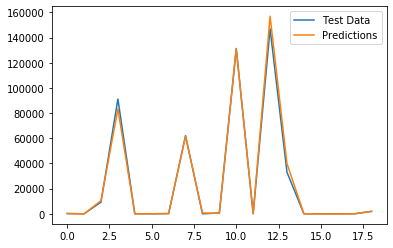

MAE: 1502.8557166961953


In [20]:
country_name = 'Germany'
x_train, x_test, x_pred, y_train, y_test = data_prep(country_name, future_date)
model = pickle.load(open('model/' + country_name + '.pkl', 'rb'))

y_test_pred = model.predict(x_test)
plt.plot(y_test)
plt.plot(y_test_pred)
plt.legend(['Test Data', 'Predictions'])
plt.show()

print('MAE:', mean_absolute_error(y_test_pred, y_test))

## Part 5: Prediction 

Predict the number of cases projection based from future_date that we defined earlier.

In [21]:
directory = 'model'
model_paths = os.listdir(directory)

for path in model_paths:
    country_name = path[:-4]
    model = pickle.load(open(directory + '/' + path, 'rb'))
    if(country_name == 'Taiwan'): country_name = 'Taiwan*'
    x_train, x_test, x_pred, y_train, y_test = data_prep(country_name, future_date)
#     poly_x_pred = poly.fit_transform(x_pred)
    
    y_proj_pred = model.predict(x_pred)
    y_proj_pred = y_proj_pred.astype('int')
    if(country_name == 'Global'): print(y_proj_pred)
    pred_df.loc[country_name, pred_dates] = y_proj_pred
    
pred_df.loc[['Global']]

[   -167    -167     189    2452    4714    6977    9240   11503   13766
   16029   18292   20555   22818   25081   27343   29606   31869   34132
   36395   38658   40921   47186   55136   63087   71037   76966   76436
   75906   75376   74672   75332   76102   77450   78797   80145   81492
   82840   84188   85535   87450   90602   93754   96905  100057  103209
  106361  109513  112665  115817  122619  130731  141458  155346  169234
  183123  197011  213494  238525  272056  305588  339119  378215  419693
  467841  530878  594029  657179  720329  783480  856822  932433 1010182
 1089668 1169154 1248641 1328127 1407615 1489722 1571829 1653936 1736043
 1818149 1900256 1982363 2064470 2146577 2228684 2310790 2392897 2475004
 2557111 2639218 2721325 2803431 2885538 2967645 3049752 3131859 3213966
 3296072 3378179 3460286 3542393 3624500 3706606 3788713]


,01/22/2020,01/23/2020,01/24/2020,01/25/2020,01/26/2020,01/27/2020,01/28/2020,01/29/2020,01/30/2020,01/31/2020,...,04/27/2020,04/28/2020,04/29/2020,04/30/2020,05/01/2020,05/02/2020,05/03/2020,05/04/2020,05/05/2020,05/06/2020
Country/Region,,,,,,,,,,,,,,,,,,,,,
Global,-167,-167,189,2452,4714,6977,9240,11503,13766,16029,...,3049752,3131859,3213966,3296072,3378179,3460286,3542393,3624500,3706606,3788713


Convert float data types to int and replacing negative value to zero.

In [22]:
pred_df[pred_dates] = pred_df[pred_dates].astype('int')
pred_df[pred_df < 0] = 0

pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186 entries, Afghanistan to Zimbabwe
Columns: 106 entries, 01/22/2020 to 05/06/2020
dtypes: int32(106)
memory usage: 83.5+ KB


Save prediction result to CSV file.

In [23]:
pred_df.info()
pred_df.to_csv('result/predictions.csv')

<class 'pandas.core.frame.DataFrame'>
Index: 186 entries, Afghanistan to Zimbabwe
Columns: 106 entries, 01/22/2020 to 05/06/2020
dtypes: int32(106)
memory usage: 83.5+ KB


## About the Author 

This notebook was written by Ekky Rino Fajar Sakti. He received Bachelor Degree in Computer Science from Ma Chung University. Currently, He is a Data Scientist which helps to build Data Solution for stakeholder. His passion is Data Science, Big Data, and Machine Learning. 
 - Email: ekky.rino@gmail.com
 - LinkedIn: https://www.linkedin.com/in/ekky-rino/